# Going deeper with Tensorflow

熟悉tensorflow
1. 观察 tensorflow 与 numpy 计算效率的比较
2. 熟悉 tensorboard，可以看到一些流程，非常赞
3. 熟悉 tf.gradients
4. 熟悉 tensorflow 的optimizer，了解它是怎样声明和使用的。并且可以用图形显示优化过程。
5. 实战：使用tensorflow 做 logistic regression


小结：
1. 都是一些基本用法。但是 tensorboard 对我来说还比较新鲜， 有些用法还是不习惯
2. 画图很有意义
3. 知道怎么用optimizer手动实现 一个 logistic regression。

> 机器学习的配方是 准备数据，设计模型、代价函数、优化过程

In [3]:
! killall tensorboard

No matching processes belonging to you were found


In [19]:
import sys
sys.path.append("..")

! killall tensorboard
import os
os.system("tensorboard --logdir=/tmp/tboard --port=7007 &");

import tensorflow as tf

No matching processes belonging to you were found


## tensorflow计算速度

In [5]:
import numpy as np
def sum_sin(N):
    return np.sum(np.arange(N)**2)

In [6]:
%%time
sum_sin(10**8)

CPU times: user 879 ms, sys: 1.92 s, total: 2.79 s
Wall time: 3.86 s


662921401752298880

In [20]:

tf.reset_default_graph()
s = tf.InteractiveSession()

# An integer parameter
N = tf.placeholder('int64', name="input_to_your_function")
# A recipe on how to produce the same result
result = tf.reduce_sum(tf.range(N)**2)
result

<tf.Tensor 'Sum:0' shape=() dtype=int64>

In [21]:
%%time
result.eval({N: 10**8})

CPU times: user 834 ms, sys: 460 ms, total: 1.29 s
Wall time: 1.29 s


662921401752298880

可以观察到 tensorflow的速度 快于 numpy计算速度。  尤其是sys部分。

上面用到了几个概念：
- InteractiveSession， 大概是交互式Session，可以实时运算
- [placeholder](https://www.tensorflow.org/versions/master/api_docs/python/tf/placeholder)，占位符，参数有 dtype 、shape 和name，一般用作 训练数据的输入输出
- reduce_sum， 等同于 numpy的 sum
- range，等同于 numpy的 arange

## 熟悉tensorflow 和tensorboard

In [23]:
# 将 session 中的 graph 写入 tensorboard 的log
writer = tf.summary.FileWriter("/tmp/tboard", graph=s.graph)


In [27]:
# 理解为命名空间： name_scope

# 重置 graph 和 session
tf.reset_default_graph()
s = tf.InteractiveSession()
writer = tf.summary.FileWriter("/tmp/tboard", graph=s.graph)

with tf.name_scope("Placeholders_examples"):
    # Default placeholder that can be arbitrary float32
    # scalar, vertor, matrix, etc.
    arbitrary_input = tf.placeholder('float32')

    # Input vector of arbitrary length
    input_vector = tf.placeholder('float32', shape=(None,))

    # Input vector that _must_ have 10 elements and integer type
    fixed_vector = tf.placeholder('int32', shape=(10,))

    # Matrix of arbitrary n_rows and 15 columns
    # (e.g. a minibatch your data table)
    input_matrix = tf.placeholder('float32', shape=(None, 15))
    
    # You can generally use None whenever you don't need a specific shape
    input1 = tf.placeholder('float64', shape=(None, 100, None))
    input2 = tf.placeholder('int32', shape=(None, None, 3, 224, 224))

    # elementwise multiplication
    double_the_vector = input_vector*2

    # elementwise cosine
    elementwise_cosine = tf.cos(input_vector)

    # difference between squared vector and vector itself plus one
    vector_squares = input_vector**2 - input_vector + 1

In [28]:
my_vector =  tf.placeholder('float32', shape=(None,), name="VECTOR_1")
my_vector2 = tf.placeholder('float32', shape=(None,))
my_transformation = my_vector * my_vector2 / (tf.sin(my_vector) + 1)
print(my_transformation)

Tensor("truediv:0", shape=(?,), dtype=float32)


In [29]:
dummy = np.arange(5).astype('float32')
print(dummy)

# 计算输出的方法： 给placeholder赋值， eval计算输出
my_transformation.eval({my_vector:dummy, my_vector2:dummy[::-1]})

[ 0.  1.  2.  3.  4.]


array([ 0.        ,  1.62913239,  2.09501147,  2.62899613,  0.        ], dtype=float32)

In [31]:
# 添加 my_transformation（输出）的图，刷新日志
writer.add_graph(my_transformation.graph)
writer.flush()

TensorBoard allows writing scalars, images, audio, histogram. You can read more on tensorboard usage [here](https://www.tensorflow.org/get_started/graph_viz).

### Mean squared error


In [34]:

with tf.name_scope("MSE"):
    y_true = tf.placeholder("float32", shape=(None,), name="y_true")
    y_predicted = tf.placeholder("float32", shape=(None,), name="y_predicted")
    # Your code goes here
    # You want to use tf.reduce_mean
    mse = tf.reduce_mean((y_predicted - y_true)**2)
    
def compute_mse(vector1, vector2):
    return mse.eval({y_true: vector1, y_predicted: vector2})

In [35]:
writer.add_graph(mse.graph)
writer.flush()

### Variables

variable 可以用作设计参数，是在operation中变化的量

- 初始化值和shape
- 使用 `global_variables_initializer` 初始化
- 使用 `assign` 赋值

In [36]:
# Creating a shared variable
shared_vector_1 = tf.Variable(initial_value=np.ones(5),
                              name="example_variable")

In [37]:
# Initialize variable(s) with initial values
s.run(tf.global_variables_initializer())

# Evaluating shared variable (outside symbolicd graph)
print("Initial value", s.run(shared_vector_1))

# Within symbolic graph you use them just
# as any other inout or transformation, not "get value" needed

Initial value [ 1.  1.  1.  1.  1.]


In [38]:
# Setting a new value
s.run(shared_vector_1.assign(np.arange(5)))

# Getting that new value
print("New value", s.run(shared_vector_1))

New value [ 0.  1.  2.  3.  4.]


### tf.gradients 

tensorflow 可以计算每个operatoin的梯度值

In [39]:
my_scalar = tf.placeholder('float32')

scalar_squared = my_scalar**2

# A derivative of scalar_squared by my_scalar
derivative = tf.gradients(scalar_squared, [my_scalar, ])

In [40]:
derivative

[<tf.Tensor 'gradients/pow_grad/Reshape:0' shape=<unknown> dtype=float32>]

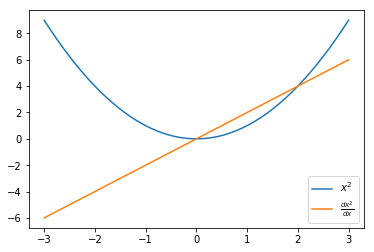

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-3, 3)
x_squared, x_squared_der = s.run([scalar_squared, derivative[0]],
                                 {my_scalar:x})

plt.plot(x, x_squared,label="$x^2$")
plt.plot(x, x_squared_der, label=r"$\frac{dx^2}{dx}$")
plt.legend();

#### 更复杂的梯度

下面这个例子不用理解意思。就是知道经过若干复杂缠绕的（无回路）的操作后，也能计算梯度

In [42]:
my_vector = tf.placeholder('float32', [None])
# Compute the gradient of the next weird function over my_scalar and my_vector
# Warning! Trying to understand the meaning of that function may result in permanent brain damage
weird_psychotic_function = tf.reduce_mean(
    (my_vector+my_scalar)**(1+tf.nn.moments(my_vector,[0])[1]) + 
    1./ tf.atan(my_scalar))/(my_scalar**2 + 1) + 0.01*tf.sin(
    2*my_scalar**1.5)*(tf.reduce_sum(my_vector)* my_scalar**2
                      )*tf.exp((my_scalar-4)**2)/(
    1+tf.exp((my_scalar-4)**2))*(1.-(tf.exp(-(my_scalar-4)**2)
                                    )/(1+tf.exp(-(my_scalar-4)**2)))**2

der_by_scalar = tf.gradients(weird_psychotic_function, my_scalar)
der_by_vector = tf.gradients(weird_psychotic_function, my_vector)

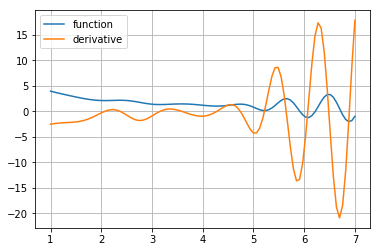

In [43]:
# Plotting the derivative
scalar_space = np.linspace(1, 7, 100)

y = [s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 2, 3]})
     for x in scalar_space]

plt.plot(scalar_space, y, label='function')

y_der_by_scalar = [s.run(der_by_scalar,
                         {my_scalar:x, my_vector:[1, 2, 3]})
                   for x in scalar_space]

plt.plot(scalar_space, y_der_by_scalar, label='derivative')
plt.grid()
plt.legend();

## optimizer

比如 momentum 或者 RMSProp 或者 Adam

In [46]:
# y_guess 是变量，是需要优化的量，初始化为一个 (2,) 的零向量
y_guess = tf.Variable(np.zeros(2, dtype='float32'))
# y_true 是目标值，固定坐标 (1, 3)
y_true = tf.range(1, 3, dtype='float32')

# loss 是y_true 和y_guess的 MSE， 加上一个 (2,) 正态分布的噪声
loss = tf.reduce_mean((y_guess - y_true + tf.random_normal([2]))**2) 
# loss = tf.reduce_mean((y_guess - y_true)**2) 

# 定义一个MomentumOptimizer，目标是优化 loss，变量列表是 y_guess
optimizer = tf.train.MomentumOptimizer(0.01, 0.5).minimize(loss, var_list=y_guess)

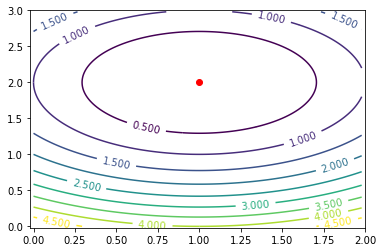

In [47]:
from matplotlib import animation, rc
import matplotlib_utils
from IPython.display import HTML, display_html

# 基本图形
fig, ax = plt.subplots()
y_true_value = s.run(y_true)
level_x = np.arange(0, 2, 0.02)
level_y = np.arange(0, 3, 0.02)
X, Y = np.meshgrid(level_x, level_y)
Z = (X - y_true_value[0])**2 + (Y - y_true_value[1])**2
ax.set_xlim(-0.02, 2)
ax.set_ylim(-0.02, 3)
s.run(tf.global_variables_initializer())
# 目标位置
ax.scatter(*s.run(y_true), c='red')
# loss的 cotour图
contour = ax.contour(X, Y, Z, 10)
ax.clabel(contour, inline=1, fontsize=10)
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)

guesses = [s.run(y_guess)]

# 每次 run(optimizer) 将y_guess 结果添加到 guesses， 其坐标放到line中
def animate(i):
    s.run(optimizer)
    guesses.append(s.run(y_guess))
    line.set_data(*zip(*guesses))
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=400, interval=20, blit=True)

In [48]:
try:
    display_html(HTML(anim.to_html5_video()))
# In case the build-in renderers are unaviable, fall back to
# a custom one, that doesn't require external libraries
except RuntimeError:
    anim.save(None, writer=matplotlib_utils.SimpleMovieWriter(0.001))

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAorj/AAR%2B0J8A/iZ431n4Z/Dj44eD/EHiTw5JJH4h8P6J4ltbu%2B0t0kMTrcQRSNJAVkBQh1GGG088VZtfjb8Gb74p3PwLsvi54Ym8b2dgL288HRa/btqsFqQpE72gfzljIdPnK7fmXnkUAdPRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfIz%2BIrvxH/wUT0j40aVp3xZ1nw/4Z8I6/pWr2XiP4WX%2Bn6b4Ukmn0yMNpUo06CbVWu5bUtJiS%2BRUQyxvbxjbLy/g74f/EGL9qTw98N5fhR4oh17Qf2nfEnj3WvGcvhq6TSpvDt5oWp29tImpmP7NPIVvbDT/sqyGZPszMYxHCr19w0UAeIftr%2BO/wBp34WeFtF8bfAPx94D022ufF/hzw/qFj4v8B3uqyO%2Bq67Y6X9ojlttVsxGIkvDJ5ZR95jA3oDkWf8AhB/%2BChf/AEdB8Gf/AAw%2Brf8AzUUft4f8kQ0P/ss3w4/9TXRK9moA8Z/4Qf8A4KF/9HQfBn/ww%2Brf/NRVbWdA/bz8OaRdeIPEP7W3wQsLCyt3nvb29%2BB2qRQ28SAs0ju3ikKigAkkkAAZrtvhz8ddL%2BIPxC8S/DO58F65oGp%2BHTHIkWuxQx/2nZvJNEt5biOVy0JlglTLBW4UlQHUnwnxj4Y%2BMnh7SfE/w8%2BNujX%2BsaZ8RPFEvhqz8ZS%2BM3nuFS8eQ2EkOlRwrDawQsyQuY2EpCNOwKqSOulhHOfLN2emnVp9tbOyu/6dsZ1Uo3Svv/X3lHxB8b/27NYt/Cy/AD9pj4A%2BOLnxXqV3bWWPhRqtnboLWBp58y/8JHKfNCqAsRUFtwJKoC47H4Paz%2B3j8Zfh1p3xD0P9pT4RWkd4JYrqwvPgJqyz2V1DK8FxbSj/AISjiSKaOSNscbkOOKzfC3wc%2BK/xk%2BI914s8Z%2BCNU8Aatplhpl2de32sscviW1M0TXVtHHI3m272k8sT7wm%2BO5ZPvLlPb/gn8K5vhL4RuNG1LxGNX1PUtYvNV1nU0sVtUuLu5lMkjJCpYRoMgBdzHC5LMSSdcTTwtKlyxfvffvfqtNrbWflrpNKVWUrvb%2BvmeEeBx/wWR8RfFHWNF8XeKPgJ4e8H2FxPDpniCf4dapc32qbWxHMlnF4gKRRuAW/eThxkZTOcegf8IP8A8FC/%2BjoPgz/4YfVv/mor2aiuKclN3UUvS/6tm0U0tXc8Z/4Qf/goX/0dB8Gf/DD6t/8ANRR/wg//AAUL/wCjoPgz/wCGH1b/AOaivZqw/iF8T/ht8JPDsni/4qfEDRPDWlQ/63Ute1SGzgXjODJKyrn8amMZSdoq7K3PNf8AhB/%2BChf/AEdB8Gf/AAw%2Brf8AzUUf8IP/AMFC/wDo6D4M/wDhh9W/%2BaiuQn/4Kh/BjxncPpn7Lfwu%2BInxlulcx/afAPhOX%2BzEkzgB9SvDBaBf9pZH78HFNHiv/gqv8XOfD3wo%2BFXwe0%2BX5Wl8V65ceJtVjH98QWQgtVb2M7jPr1rs/s/ER/i2h/iaT%2B7WX/kpfJLrodj/AMIP/wAFC/8Ao6D4M/8Ahh9W/wDmorK8XH9tXwBpZ1vx5%2B2j8BNEsl%2B9eav8F9Stoh/wOTxUB%2BtYn/DB3xr%2BIH779or/AIKJfFfXc8PpvgZ7TwnYsvdStjGbgj63BODyTWt4R/4JZ/sB%2BE9UGv3H7NOh%2BItT6vqnjiWfX7h267i%2BoyTHOeeMY7Yo9lgYfHVcv8Mf1k1%2BQWgup4x4q/4KMP4T1I6Kf%2BCo37O2tXwyBZeD/gRrmuzE%2BgTTvEs5J7YxWb/w3d%2B3rr//ACSnwjrXi1H/AOPe8tP2O9a022l9CJdT8W2w2%2B/P0r7m8K%2BCvBvgTTRovgjwlpmjWa/dtNKsI7eIf8BjUD9K06Pa4CPw0pP1lb8Ix/ULw7HwPH8av%2BDgjxA4bwj%2BzN8I7OBz8k3jHRfsJx6lLTxNeMv0IzXffCy1/wCC7ev%2BI7T/AIW94p/ZT8N6I%2B77ZLo/hPxHqd9F8jbdsTalBE3z7QcyjAJPJAB%2BuqKieIpSjaNKK/8AAm/xl%2BgnJdjxn/hB/wDgoX/0dB8Gf/DD6t/81FH/AAg//BQv/o6D4M/%2BGH1b/wCaivZqK5STxn/hB/8AgoX/ANHQfBn/AMMPq3/zUUf8IP8A8FC/%2BjoPgz/4YfVv/mor2aigDxn/AIQf/goX/wBHQfBn/wAMPq3/AM1FH/CD/wDBQv8A6Og%2BDP8A4YfVv/mor2aigDxn/hB/%2BChf/R0HwZ/8MPq3/wA1FH/CD/8ABQvt%2B1B8Gf8Aww%2Brf/NRXs1FAHxJ4k1P/g4i8P7pdK0j9kfX0H3E0%2Bw8RW8jD3E96qg/8CNYI/aJ/wCC63hg%2Bd8Sv2XvBot1/wBZP4J8CQ6wf%2BAxyeMLaRv%2B%2BRX3zRXZHE0bWlRi/wDwJflJ/kVzLsfK/wCz98Sv%2BChPx%2B0zUr9/GnhvwRNpk8cU1j8Qf2YtX06WYspO6EjxY6TKMYLIxAJA71pfEvxF/wAFBvh74t8EeC7f9oL4M6he%2BNvEj6Xbr/wpTVYRaxRWNzeTXJ/4qZt4VLbbs%2BXLSKNwr6Wrzbx/%2BzPoHjv4y6D8dU%2BI/jDSdb8O288NhbafrKyaeVmiaKQtZ3EcsIYqeXRVf5R83XMU5Yd13Jq0bOy1lrZ27PfW/QFy3PBf2g/jh/wUO%2BCWpXmmaH8V/hH4kfQPDMniXxhJD8GdStk0nR42kDT5fxOTNKfJmKQqAWELfMOM60Hxz/aoufinb/CGL9rP4VnUrm7SyS7/AOGbde%2BwrfvaC8Wxa6/4SXyluTbETeUWB2%2B4xXb/ABj/AGSvHXxJ8U31xpHxXtLTR/Fvh6w0bx8l1ope9u7e1mkk3WsiSpHCZlkeGRWjZQrFkw2c8PqP7PH7SK6v4g8LaD4b06z0/TfFeu%2BL9B8S/wBqKf7Sv5bcppVsIBmSLySyrK78MLddmRIQnXTo4GpSScrO3e333XR9F038qSg0dT4Q179rv4gavqvh/wACftzfs%2Ba1qGhXAg1ux0r4O6hcTafISQEnRPFZaIkq2AwGcH0rf/4Qf/goX/0dB8Gf/DD6t/8ANRXF/sZeCtWfxvoXiLRPBHiDw54Z8GfCDTvCaQeJdBm0271HUzMJrl3imVXkEIiTE2NjyXc5RnBLH0f4l/ttfsqfBj4q2/wW%2BMHxs0fwr4gu7OO5s4vEbPZW1wjlgoS7mVbdnypygk3jIyBuGeethJKu6dFOVlfRXfntfyfW1yXHWyMz/hB

# Logistic regression



y [shape - (360,)]: [0 1 0 1 0 1 0 0 1 1]
X [shape - (360, 64)]:
X:
 [[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.]
 [  0.   0.   0.  12.  13.   5.   0.   0.   0.   0.]
 [  0.   0.   1.   9.  15.  11.   0.   0.   0.   0.]]
y:
 [0 1 0 1 0 1 0 0 1 1]


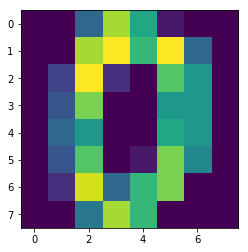

In [50]:
# 准备数据 （sklearn.datasets）

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

mnist = load_digits(2)

X, y = mnist.data, mnist.target

print("y [shape - %s]:" % (str(y.shape)), y[:10])
print("X [shape - %s]:" % (str(X.shape)))

print('X:\n',X[:3,:10])
print('y:\n',y[:10])
plt.imshow(X[0].reshape([8,8]));

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

It's your turn now!
Just a small reminder of the relevant math:

$$
P(y=1|X) = \sigma(X \cdot W + b)
$$
$$
\text{loss} = -\log\left(P\left(y_\text{predicted} = 1\right)\right)\cdot y_\text{true} - \log\left(1 - P\left(y_\text{predicted} = 1\right)\right)\cdot\left(1 - y_\text{true}\right)
$$

$\sigma(x)$ is available via `tf.nn.sigmoid` and matrix multiplication via `tf.matmul`

In [52]:
# 准备模型、代价函数、优化过程

# Model parameters - weights and bias
weights = tf.Variable(np.zeros((X.shape[1], 1), dtype='float32')) #shape should be (X.shape[1], 1)
b = tf.Variable(0.0, dtype='float32')

# Placeholders for the input data
input_X = tf.placeholder(tf.float32, shape=(None, X.shape[1]))
input_y = tf.placeholder(tf.float32, shape=(None, ))

# Compute a vector of predictions, resulting shape should be [input_X.shape[0],]
predicted_y = tf.sigmoid(tf.squeeze(tf.matmul(input_X, weights) + b))

# 代价函数
loss = tf.reduce_mean(-input_y * tf.log(predicted_y) - (1- input_y) * tf.log(1 - predicted_y))

# 优化器、优化目标、参数列表
optimizer = tf.train.AdamOptimizer().minimize(loss, var_list=[weights, b])


In [54]:

# 使用前面的 weird_psychotic_function 生成一个 weights
validation_weights = 1e-3 * np.fromiter(
    map(lambda x: s.run(weird_psychotic_function, {
        my_scalar: x, 
        my_vector: [1, 0.1, 2]
    }), 0.15 * np.arange(1, X.shape[1] + 1)), 
    count=X.shape[1], 
    dtype=np.float32
)[:, np.newaxis]

# 使用 weights 和b 计算 predicted_y
prediction_validation = s.run(predicted_y, {
    input_X: X,
    weights: validation_weights,
    b: 1e-1
})

# 验证一下
validation_true_values = np.loadtxt("validation_predictons.txt")

assert prediction_validation.shape == (X.shape[0],),\
       "Predictions must be a 1D array with length equal to the number " \
       "of examples in input_X"
assert np.allclose(validation_true_values, prediction_validation)

# 计算loss并验证
loss_validation = s.run(
        loss, {
            input_X: X[:100],
            input_y: y[-100:],
            weights: validation_weights+1.21e-3,
            b: -1e-1})
assert np.allclose(loss_validation, 0.728689)

In [55]:
# 运行几次optimizer，就可以训练好数据（因为非常简单），得到 auc = 1

from sklearn.metrics import roc_auc_score
s.run(tf.global_variables_initializer())
for i in range(5):
    s.run(optimizer, {input_X: X_train, input_y: y_train})
    loss_i = s.run(loss, {input_X: X_train, input_y: y_train})
    print("loss at iter %i:%.4f" % (i, loss_i))
    print("train auc:", roc_auc_score(y_train, s.run(predicted_y, {input_X:X_train})))
    print("test auc:", roc_auc_score(y_test, s.run(predicted_y, {input_X:X_test})))

loss at iter 0:0.6393
train auc: 1.0
test auc: 1.0
loss at iter 1:0.5895
train auc: 1.0
test auc: 1.0
loss at iter 2:0.5433
train auc: 1.0
test auc: 1.0
loss at iter 3:0.5007
train auc: 1.0
test auc: 1.0
loss at iter 4:0.4614
train auc: 1.0
test auc: 1.0


In [56]:
test_weights = 1e-3 * np.fromiter(map(lambda x:
    s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 2, 3]}),
                               0.1 * np.arange(1, X.shape[1] + 1)),
                               count=X.shape[1], dtype=np.float32)[:, np.newaxis]
prediction_test = s.run(
    predicted_y, {
    input_X: X,
    weights: test_weights,
    b: 1e-1})

print(prediction_test)

[ 0.66401088  0.65641075  0.67593837  0.66138738  0.68129277  0.67558366
  0.68500489  0.68207365  0.63350755  0.64254004  0.66639584  0.65949732
  0.694121    0.66115284  0.64544779  0.68306303  0.67686367  0.67107213
  0.66392851  0.64235556  0.64538926  0.65905392  0.6561361   0.65742481
  0.63385147  0.68329191  0.64337552  0.66489387  0.68337435  0.66179073
  0.66177893  0.64671141  0.69986385  0.67688763  0.68746978  0.66472566
  0.69620609  0.66244704  0.69127142  0.68220872  0.65086454  0.67770666
  0.68905181  0.67274594  0.6785143   0.64218765  0.65662456  0.6957922
  0.66311967  0.67081583  0.69048113  0.67225158  0.68022954  0.66433567
  0.66481322  0.63162178  0.67249894  0.67037082  0.67849028  0.68825996
  0.66681451  0.65308052  0.65186304  0.67308062  0.67225862  0.66422528
  0.6547932   0.65946996  0.68174976  0.67272311  0.63793045  0.63419807
  0.65103573  0.64098734  0.64769876  0.66859394  0.6967169   0.65998185
  0.673325    0.69064862  0.68462962  0.68061763  0.

In [79]:
assert prediction_test.shape == (X.shape[0],),\
       "Predictions must be a 1D array with length equal to the number " \
       "of examples in X_test"

In [57]:
loss_test = s.run(
    loss, {
        input_X: X[:100],
        input_y: y[-100:],
        weights: test_weights+1.21e-3,
        b: -1e-1})

print(loss_test)
# Yes, the X/y indices mistmach is intentional

0.775012
